<a href="https://colab.research.google.com/github/AgarwalMayank2/Face_Detection/blob/main/processing_dataset/feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print(path)

100%|██████████| 112M/112M [00:00<00:00, 136MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4


In [2]:
import os
images_address="/root/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled"
labels=os.listdir(images_address)
paths_of_images=[]
for root, dirs, files in os.walk(images_address):
    for file in files:
        paths_of_images.append(os.path.join(root, file))

print(paths_of_images[:5])

['/root/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled/Raja_Qureshi/Raja_Qureshi_0001.jpg', '/root/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled/Crispin_Glover/Crispin_Glover_0001.jpg', '/root/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled/Klaus_Schwab/Klaus_Schwab_0001.jpg', '/root/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled/Kirk_Ferentz/Kirk_Ferentz_0001.jpg', '/root/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled/Kirk_Ferentz/Kirk_Ferentz_0002.jpg']


# Filtering dataset

filtering persons who has less than 10 images and storing them in form of dictionary.

person_imagepath = {person_name : [img_path1, img_path2, img_path3, ...]}

In [12]:
import re
i=0
person_imagepath={}
for path in paths_of_images:
    i+=1
    matchpattern = re.search(r'/([^/]+)_\d+\.jpg$', path)
    if matchpattern:
        if matchpattern.group(1) not in person_imagepath:
            person_imagepath[matchpattern.group(1)]=[]
        person_imagepath[matchpattern.group(1)].append(path)

person_imagepath = {person: images for person, images in person_imagepath.items() if len(images) >= 10}
total_filtered_datapoints=0
for person in person_imagepath:
    total_filtered_datapoints+=len(person_imagepath[person])

print("total datapoints having person atleast 10 images are",total_filtered_datapoints)
print("Unique persons = ", len(person_imagepath))


total datapoints having person atleast 10 images are 4324
Unique persons =  158


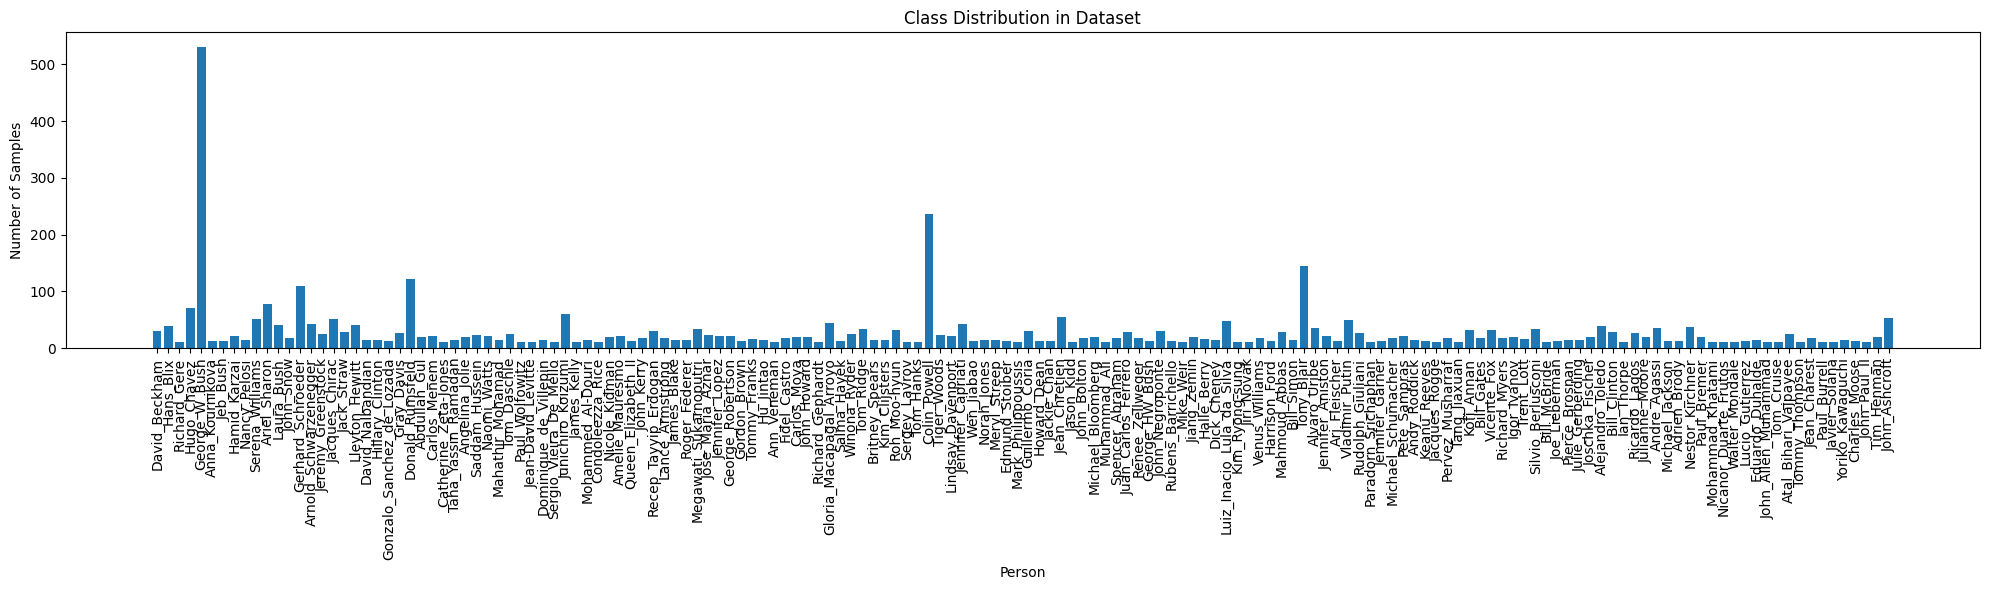

In [21]:
import numpy as np
import matplotlib.pyplot as plt

unique = person_imagepath.keys()
counts = [len(person_imagepath[person]) for person in unique]
plt.figure(figsize=(20, 6))
plt.bar(unique, counts)
plt.xlabel("Person")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Extracting features and saving processed datasets

## Extracting CNN features


Using pretrained CNN (ResNet)

In [ ]:
#This code can be used to extract pretrained CNN (ResNet) Features.
#It takes Image Path and returns 2048-dimensional feature.
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Load pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)
# Remove the last fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1])
# Set the model to evaluation mode
resnet.eval()

# Define a function to extract features from an image
def extract_features(image_path, model):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    # Add batch dimension
    image = image.unsqueeze(0)
    # Extract features
    with torch.no_grad():
        features = model(image)
    # Remove the batch dimension
    features = features.squeeze(0)
    return features

In [ ]:
# saving featrues
import pandas as pd
import numpy as np
data_list=[]
i=0
for person in person_imagepath :
  for path in person_imagepath[person]:
      i+=1
      features = extract_features(path, resnet)
      features = features.flatten().numpy()
      datapoint = np.append(features, person)
      data_list.append(datapoint)
      if i%100==0:
          print(i,"/",total_filtered_datapoints,"converted")
df = pd.DataFrame(data_list)
df.to_csv("filtered_CNN_features_dataset.csv")
df

## Extracting HoG features

In [ ]:

#This code can be used to extract Histogram of Gradient (HoG) Features.
#It takes Image Path and returns HoG feature.
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import matplotlib.pyplot as plt


def compute_hog(img):
  #resizing image
  resized_img = resize(img, (128*4, 64*4))
  #creating hog features
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)
  return fd, hog_image

#reading the image
# img = imread('example_image.png')
# Hog_feature, hog_image=compute_hog(img)
# print(Hog_feature.shape)

In [ ]:
# saving featrues
import pandas as pd
import numpy as np
data_list=[]
i=0
for person in person_imagepath :
  for path in person_imagepath[person]:
      i+=1
      img = imread(path)
      hog_features, hog_img = compute_hog(img)
      hog_features = hog_features.flatten()
      datapoint = np.append(hog_features, person)
      data_list.append(datapoint)
      if i%100==0:
          print(i,"/",total_filtered_datapoints,"converted")
df = pd.DataFrame(data_list)
df.to_csv("filtered_HOG_features_dataset.csv")
df

100 / 4324 converted
200 / 4324 converted
300 / 4324 converted
400 / 4324 converted
500 / 4324 converted
600 / 4324 converted
700 / 4324 converted
800 / 4324 converted
900 / 4324 converted
1000 / 4324 converted
1100 / 4324 converted
1200 / 4324 converted
1300 / 4324 converted
1400 / 4324 converted
1500 / 4324 converted
1600 / 4324 converted
1700 / 4324 converted
1800 / 4324 converted
1900 / 4324 converted
2000 / 4324 converted
2100 / 4324 converted
2200 / 4324 converted
2300 / 4324 converted
2400 / 4324 converted
2500 / 4324 converted
2600 / 4324 converted
2700 / 4324 converted
2800 / 4324 converted
2900 / 4324 converted
3000 / 4324 converted
3100 / 4324 converted
3200 / 4324 converted
3300 / 4324 converted
3400 / 4324 converted
3500 / 4324 converted
3600 / 4324 converted
3700 / 4324 converted
3800 / 4324 converted
3900 / 4324 converted
4000 / 4324 converted
4100 / 4324 converted
4200 / 4324 converted
4300 / 4324 converted


,0,1,2,3,4,5,6,7,8,9,...,70299,70300,70301,70302,70303,70304,70305,70306,70307,70308
0,0.14762175464086796,0.0,0.010496414792993704,0.010479682943016459,0.030299733665927125,0.008548200494437875,0.005576727787786401,0.0065852263231410664,0.021225975146851633,0.20465854649643347,...,0.020417578038180423,0.0099710035402326,0.008645630353542213,0.014163551414585838,0.0494683553052564,0.0039296791111253174,0.0010013015768249073,0.006818342465244953,0.02122201841342723,Tim_Henman
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tim_Henman
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tim_Henman
3,0.13276086010462,0.0,0.0,0.0,0.0026651144384633725,0.0,0.0,0.0,0.0,0.5650263256368628,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tim_Henman
4,0.2021439037902008,0.03209830761777675,0.033960908245639625,0.027989973264884917,0.3170992416718751,0.058462444234831934,0.03390332117391205,0.03421889184408529,0.16656688916698525,0.32061967440051686,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tim_Henman
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00010743282355217543,0.0,0.0,0.0016914153173510948,0.20469573406039906,0.01715353057069254,0.002553326993334594,0.0,0.0,Pervez_Musharraf
4320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pervez_Musharraf
4321,0.38920812921734227,0.0,0.0,0.0,2.530705036873063e-16,0.0,0.0,0.0,0.2727813206388221,0.3324059520190073,...,0.41478397903341463,0.0596314200274305,0.19745111598836038,0.23125382463705285,0.41478397903341463,0.0,0.003690899419782453,0.0,0.03687060283190775,Pervez_Musharraf
4322,0.6396522979964985,0.0,0.0,0.0,0.0005243290285007619,0.0,0.0,0.0,0.20893738365089917,0.03211613644803796,...,0.3105738036886884,0.010139715659110574,0.0,0.0,0.06385592448937961,0.03986230451900935,0.009866281725676601,0.2231779516680972,0.3105738036886884,Pervez_Musharraf


## Extracting LBP features

In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.2 MB/s eta 0:00:00


In [ ]:
#This code can be used to extract Local Binary Pattern (LBP) Features.
#It takes Image Path and returns LBP feature.
import cv2
import numpy as np
from matplotlib import pyplot as plt

def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img, center, x, y+1))       # right
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img, center, x, y-1))       # left
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img, center, x-1, y))       # top

    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val


def calcLBP(img):
    height, width, channel = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_lbp = np.zeros((height, width,3), np.uint8)
    for i in range(0, height):
        for j in range(0, width):
             img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
    hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
    return hist_lbp


# image_file = 'example_img.png'
# img = cv2.imread(image_file)
# lbpFeature=calcLBP(img)
# print(lbpFeature)

In [ ]:
# saving featrues
import pandas as pd
import numpy as np
data_list=[]
i=0
for person in person_imagepath :
  for path in person_imagepath[person]:
      i+=1
      img = cv2.imread(path)
      lbp_features = calcLBP(img)
      lbp_features = lbp_features.flatten()
      datapoint = np.append(lbp_features, person)
      data_list.append(datapoint)
      if i%100==0:
          print(i,"/",total_filtered_datapoints,"converted")
df = pd.DataFrame(data_list)
df.to_csv("filtered_LBP_features_dataset.csv")
df

100 / 4324 converted
200 / 4324 converted
300 / 4324 converted
400 / 4324 converted
500 / 4324 converted
600 / 4324 converted
700 / 4324 converted
800 / 4324 converted
900 / 4324 converted
1000 / 4324 converted
1100 / 4324 converted
1200 / 4324 converted
1300 / 4324 converted
1400 / 4324 converted
1500 / 4324 converted
1600 / 4324 converted
1700 / 4324 converted
1800 / 4324 converted
1900 / 4324 converted
2000 / 4324 converted
2100 / 4324 converted
2200 / 4324 converted
2300 / 4324 converted
2400 / 4324 converted
2500 / 4324 converted
2600 / 4324 converted
2700 / 4324 converted
2800 / 4324 converted
2900 / 4324 converted
3000 / 4324 converted
3100 / 4324 converted
3200 / 4324 converted
3300 / 4324 converted
3400 / 4324 converted
3500 / 4324 converted
3600 / 4324 converted
3700 / 4324 converted
3800 / 4324 converted
3900 / 4324 converted
4000 / 4324 converted
4100 / 4324 converted
4200 / 4324 converted
4300 / 4324 converted


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,589.0,57.0,319.0,205.0,67.0,4.0,195.0,466.0,370.0,32.0,...,474.0,1924.0,612.0,26.0,357.0,592.0,523.0,328.0,6088.0,Tim_Henman
1,1012.0,113.0,383.0,203.0,76.0,11.0,205.0,369.0,505.0,59.0,...,591.0,2086.0,681.0,29.0,447.0,699.0,535.0,486.0,13472.0,Tim_Henman
2,920.0,92.0,288.0,152.0,107.0,18.0,192.0,403.0,313.0,39.0,...,461.0,1812.0,579.0,41.0,428.0,597.0,411.0,374.0,11673.0,Tim_Henman
3,1068.0,85.0,447.0,298.0,90.0,11.0,293.0,732.0,546.0,53.0,...,727.0,2150.0,650.0,32.0,374.0,564.0,585.0,367.0,5449.0,Tim_Henman
4,510.0,43.0,304.0,189.0,47.0,8.0,201.0,387.0,296.0,18.0,...,405.0,3263.0,588.0,36.0,307.0,593.0,350.0,328.0,4606.0,Tim_Henman
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319,706.0,56.0,472.0,226.0,85.0,6.0,268.0,461.0,325.0,31.0,...,539.0,1579.0,513.0,27.0,340.0,430.0,537.0,305.0,9133.0,Pervez_Musharraf
4320,1459.0,118.0,656.0,379.0,130.0,10.0,406.0,572.0,647.0,45.0,...,728.0,1208.0,689.0,30.0,374.0,669.0,864.0,332.0,8567.0,Pervez_Musharraf
4321,907.0,103.0,441.0,375.0,104.0,12.0,394.0,887.0,390.0,51.0,...,536.0,3389.0,619.0,29.0,356.0,656.0,579.0,353.0,4020.0,Pervez_Musharraf
4322,525.0,44.0,277.0,194.0,49.0,4.0,246.0,456.0,361.0,32.0,...,664.0,2049.0,779.0,31.0,643.0,656.0,469.0,515.0,11051.0,Pervez_Musharraf
